# Assignment 6
# Convolutional Neural Network for Cassification Task in PyTorch

Name: Duncan Conly

UA ID: 010958878

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [49]:


# Define the transform: convert to tensor and normalize with mean=0 and std=1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))  # (mean, std) per RGB channel
])

# Load CIFAR-10 training dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

# Load CIFAR-10 test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)



# Lets look at some charatersitics of the training data
# Note here the targets are stored as list so we have to use len() not shape
print('Input data shape is:', train_dataset.data.shape)
print('The Target size is:', len(train_dataset.targets))
print('Maximum value of entry in data is:', train_dataset.data.max())
print('Minimum value of entry in data is:', train_dataset.data.min())



Input data shape is: (50000, 32, 32, 3)
The Target size is: 50000
Maximum value of entry in data is: 255
Minimum value of entry in data is: 0


In [50]:
batch_size = 8

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# CIFAR-10 class labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



In [51]:
batch_example = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2, shuffle=True)

for i, data in enumerate(batch_example, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data
    print('The shape of data is:', inputs.shape)      # Expected: [2, 3, 32, 32]
    print('The shape of target is:', labels.shape)    # Expected: [2]
    print('Maximum value of entry in data is:', inputs.max())
    print('Minimum value of entry in data is:', inputs.min())
    break  # just look at the first batch


The shape of data is: torch.Size([2, 3, 32, 32])
The shape of target is: torch.Size([2])
Maximum value of entry in data is: tensor(1.)
Minimum value of entry in data is: tensor(0.)


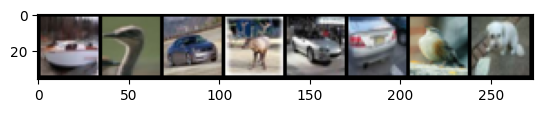

ship bird car deer car car bird dog


In [52]:
# functions to show an image
def imshow(img):
 npimg = img.numpy()
 plt.imshow(np.transpose(npimg, (1, 2, 0)))
 plt.show()
# get some random training images. iter() creates an iterator for a list.
# next(will will give us next object in the iterator
dataiter = iter(train_loader)
images, labels = next(dataiter)
images.shape
labels.shape
# show images
'''4D mini-batch Tensor of shape (B x C x H x W) or a list of images all of
the same size.
'''
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:2s}' for j in range(batch_size)))


In [53]:
# Lets build a simple CNN with a two convolution layer.
'''torch.nn.Conv2d(in_channels, out_channels,
kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode
'''
class CNN2Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5) # Inchannel = 3, out_channel (Number of
        self.pool = nn.MaxPool2d(2, 2) # kernel size = 2, stride =2
        self.conv2 = nn.Conv2d(8, 16, 5) # Note how the out_channel dim of prev
        self.fc1 = nn.Linear(16 * 5 * 5, 80)
        self.fc2 = nn.Linear(80, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1) # flatten all dimensions except batch which is i
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
model = CNN2Model() # model is an object of type CNN2Model() class

In [54]:
# Choose Device

device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print('The device being used is:', device)
model.to(device) 

The device being used is: cpu


CNN2Model(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=10, bias=True)
)

In [55]:

# Choose the Loss Function and Optimizer.
# Adam optimizer is one of the optimization technique used in NN similar to Gra
# Lets not worry abput this for now.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())


In [56]:
# Define some training parameters, initlialize some variables to store results
num_epochs = 10
train_losses = np.zeros(num_epochs)  # used to save loss at each epoch so we could plot
test_losses = np.zeros(num_epochs)

# Run Training for Num Epochs. In one epoch all training data is passed through the model
for n in range(num_epochs):
    train_loss = []  # train loss during each iteration
    
    # train_loader/test loader creates batches of data to pass into model instead
    # Notice here in one epoch all training and test data is passed once through
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # data is moved to the device
        optimizer.zero_grad()
        outputs = model(inputs)  # Forward pass of the model
        loss = criterion(outputs, labels)  # This is the loss computed for each mini-batch
        loss.backward()  # Backward pass of the model
        optimizer.step()
        train_loss.append(loss.item())  # store loss for each mini batch of the data

    # train loss and test loss for each epoch
    train_loss = np.mean(train_loss)  # train loss for each epoch

    # Lets also compute the test loss at each epoch for illustration purpose.
    test_loss = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # data is moved to the device
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # push train and test loss of each epoch
    train_losses[n] = train_loss
    test_losses[n] = test_loss
    print(f'Epoch {n+1}/{num_epochs}, Train Loss: {train_loss:.2f}, Test Loss: {test_loss:.2f}')



Epoch 1/10, Train Loss: 1.64, Test Loss: 1.48
Epoch 2/10, Train Loss: 1.40, Test Loss: 1.37
Epoch 3/10, Train Loss: 1.31, Test Loss: 1.31
Epoch 4/10, Train Loss: 1.25, Test Loss: 1.39
Epoch 5/10, Train Loss: 1.21, Test Loss: 1.23
Epoch 6/10, Train Loss: 1.18, Test Loss: 1.21
Epoch 7/10, Train Loss: 1.15, Test Loss: 1.21
Epoch 8/10, Train Loss: 1.13, Test Loss: 1.22
Epoch 9/10, Train Loss: 1.11, Test Loss: 1.25
Epoch 10/10, Train Loss: 1.10, Test Loss: 1.16


Text(0.5, 1.0, 'Training and Test Loss')

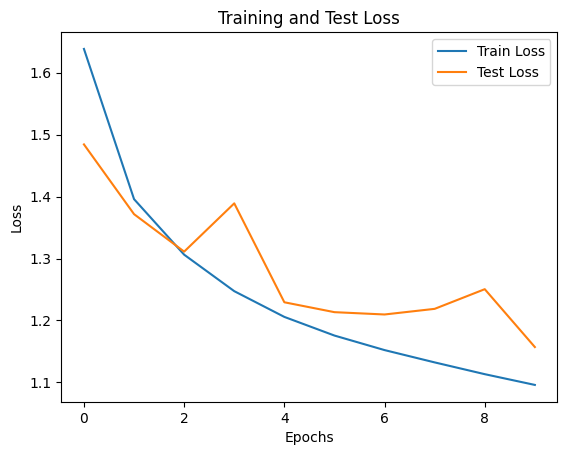

In [57]:
# plot train loss and test loss for each epoch
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')

In [58]:
# Compute Training and Test Accuracy
# We pass training data and test data through the model we trained and calculat
# For Training Data
num_correct_train = 0
num_total_train = 0
for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    # Pass train data in the model that is trained
    outputs = model(inputs)
    # Pass appropriate parameter to compute the outputs of the model for the trai
    # Output is of size 1 x numclass with predicted class having highest value. i
    val, predictions = torch.max(outputs, 1)
    # Check if prediction is correct or not and update count if prediction is cor
    num_correct_train += (predictions == labels).sum().item()
    num_total_train += labels.shape[0]
train_accuracy = num_correct_train/num_total_train
print(f'The Training Accuracy is {train_accuracy*100:.2f}%')


The Training Accuracy is 63.62%


In [59]:
# Evaluate Model: Compute Training and Test Accuracy
# We pass training data and test data through the model we trained and calculate accuracy

# For Test Data
num_correct_test = 0
num_total_test = 0
predictions_test = np.array([])  # numpy array to store predictions for entire test set
targets_test = np.array([])      # numpy array to store true targets for entire test set

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)

    # Pass test data into the model that is trained
    outputs = model(inputs)

    # Output is of size [batch_size, num_classes] — predicted class has highest value
    val, predictions = torch.max(outputs, 1)

    predictions_test = np.concatenate((predictions_test, predictions.cpu().numpy()))
    targets_test = np.concatenate((targets_test, labels.cpu().numpy()))

    # Check if prediction is correct or not and update count if correct
    num_correct_test += (predictions == labels).sum().item()
    num_total_test += labels.shape[0]


In [60]:
test_accuracy = num_correct_test/num_total_test
print(f'The Test Accuracy is {test_accuracy*100:.2f}%')


The Test Accuracy is 59.49%


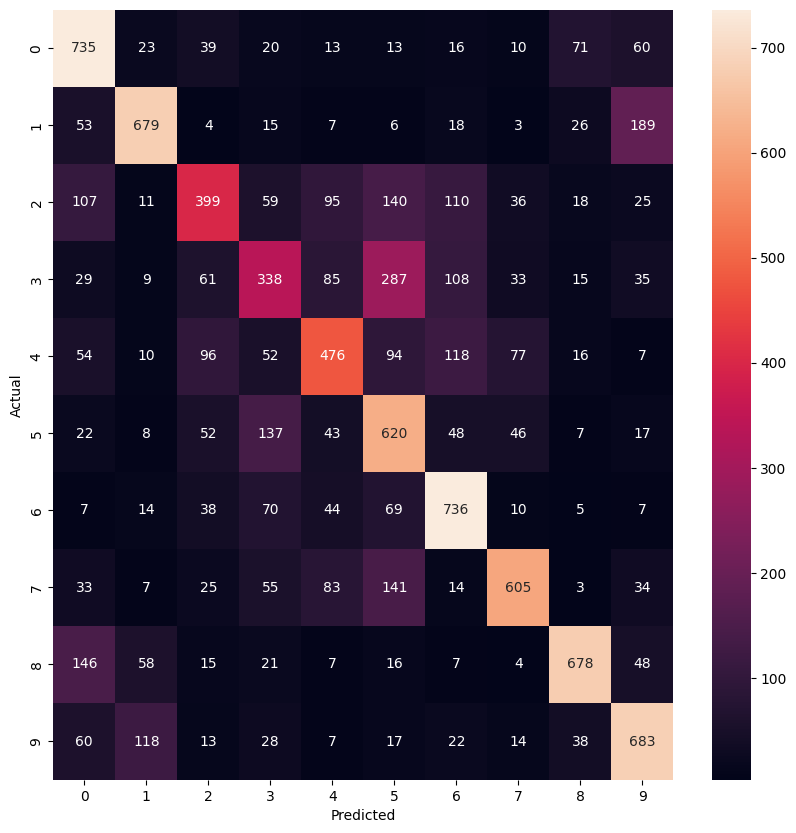

In [61]:
# Create a Confusion matrix for Test Data Prediction and actual Targets
# We will use confusion_matrix from sklearn
from sklearn.metrics import confusion_matrix  # confusion matrix takes predicted and true labels
import seaborn as sns

# Have to make some changes here compared to Assignment 2 for MNIST data because
# targets are np.array, not tensor format.
class_labels = np.unique(test_dataset.targets)
cm = confusion_matrix(targets_test, predictions_test)

# Confusion Matrix HeatMap without Normalization
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.0f', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


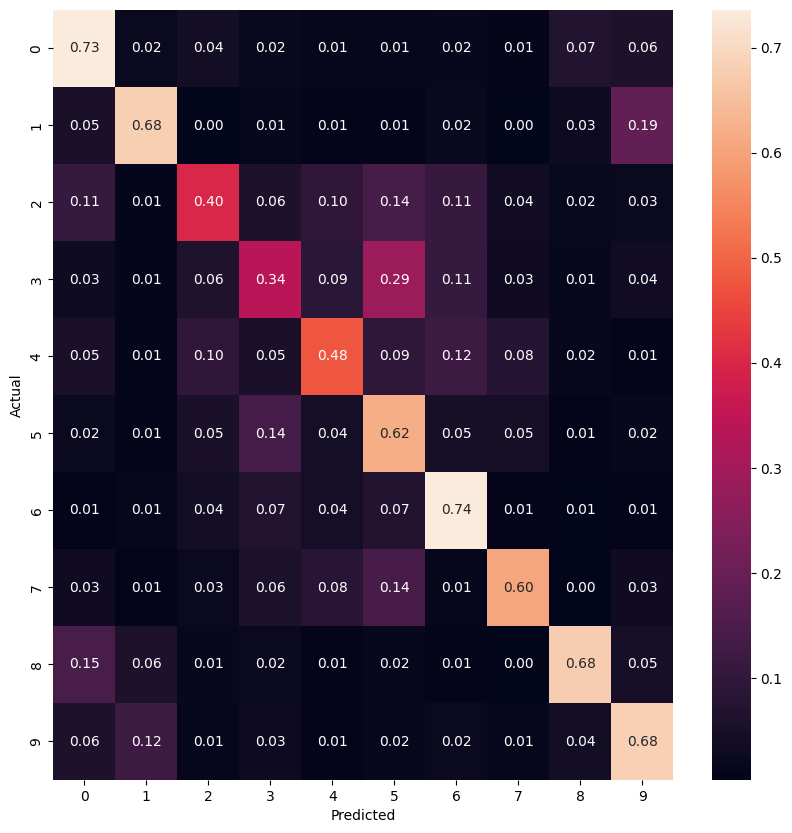

In [62]:
# Confusion Matrix HeatMap with Normalization
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=class_labels, yticklabels=class_labels)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# Question 2

In [63]:
class CNNModel(nn.Module) :
    def __init__(self) :
        super().__init__()
        # TODO: Make the initializaiton here
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=28, kernel_size=3)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=28, out_channels=64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(64 * 126 * 126, 128) # go from 64*126*126 down to 128 classes
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 15)  # from 128 to 15 classes

    def forward(self, x) :
        # TODO: Make the forward here
        x = self.conv1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)

        return x

model = CNNModel()